# 社交媒体网络技术处理 —— 社交网络评论/博客模块

## 爬虫、数据预处理、词云图模块

在本次的相关技术领域，我们尝试对项目结构进行模块化，用json格式文件进行读取，大致流程如下

先读一下 json

# 0 准备

In [2]:
import json
with open("intro.json","r",encoding="utf-8") as f:
    json_data = json.load(f)
username = json_data['username']
password = json_data['password']
webdriver_path = json_data['chrome_driver_location']
useremail = json_data['useremail']
data_store_location = json_data['data_store_location']
result_analyse_location = json_data['result_analyse_location']
result_picture = json_data['result_picture']
keyword = json_data['keyword']
keyword

'福岛 核'

## 1. 数据爬取

可自行选定社交媒体网站，例如豆瓣，微博，知乎，微信公众号，今日头条等等，

爬取小组选定分析主题相关的社交媒体文本评论数据（要求至少爬取10万条数据，请添加具体实现步骤、运行结果和相关截图）（1分）

我们通过面向对象式写法实现跨模块的调用技术

In [ ]:
from webSpyder.toutiaoSpyder import ToutiaoSpyder
toutiao = ToutiaoSpyder(webdriver_path,keyword)
toutiao.enter_key()
toutiao.getSpyNews()
toutiao.getSpyMicro()
toutiao.store_mongoDB()

# 知乎同理，进行数据获取时用到，爬取相关的评论和文章
from webSpyder.zhihuSpyder import ZhiHuSpyder
zhihu = ZhiHuSpyder(webdriver_path)
zhihu.getComments()
zhihu.getSpyContent()

# 其他模型不再赘述

## 爬取数据预处理

#### 1. 格式文本统一化

我们的数据来源比较复杂，有来着知乎、头条、微博的数据，存储格式也大有不同，
因此我们需要进行所有的数据归一化，同时执行相关的预处理操作

预处理模块的代码参考dataProcessing.py ，包括内部的一系列情况

In [3]:
import pandas as pd
import dataProcessing as dp

excelData = data_store_location+'/excelData'
mongoData = data_store_location+'/mongoData'
otherData = data_store_location+'/otherData'

excel = dp.multi_excel_combine(excelData)
mongo = dp.multi_csv_combine(mongoData)
other = dp.multi_csv_combine(otherData)
print(excel.shape)
print(mongo.shape)
print(other.shape)
print("whole raw data: ",excel.shape[0]+mongo.shape[0]+other.shape[0])

(43843, 12)
(264000, 4)
(55924, 13)
whole raw data:  363767


可以看到未处理原始评论数据集有20w条左右，下面对这些数据进行处理整合

In [4]:
# 集体去重,先处理微博的情况
df_weibo_excel = dp.data_renameweibo(excel)
df_weibo_other = dp.data_renameweibo(other)

# 对excel和other下的微博数据集体抽取并合并起来
dfA = dp.data_cut(df_weibo_excel)
dfB = dp.data_cut(df_weibo_other)
mg = dp.data_cut(mongo)

dfAB = dp.multi_pd_combine(dfA, dfB)
dfABC = dp.multi_pd_combine(dfAB, mg)
dfABC.head(10)

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
5,完美仙剑217,哎，日本这次，核泄漏，火山爆发，海啸……哎…………可怜的日本…………不知道这次是宫城县和福岛...,2011年03月13日 23:01
6,梓蒙2011,//@凤凰李淼: 福岛3号核电站随时可能爆炸。不过不是核反应堆爆炸，但即使同1号一样，是氢气...,2011年03月13日 22:56
7,梓蒙2011,//@凤凰李淼: 福岛核泄漏，日本政府最初调查非常谨慎，公布的信息很少，国民一度非常紧张。原...,2011年03月13日 22:52
8,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本，将协助日本政府处理福岛核电站的核泄...,2011年03月13日 22:50
9,Pug先生,日本核泄漏都慌妈逼啊？还记得1945年美国干了什么吗？美国佬给小日本丢了两颗原子弹！原子弹啊...,2011年03月17日 23:41


pandas中，isnull()是常用的缺失值查看方法：

    df.isnull():查看所有数据是否为缺失值，返回bool值。True：缺失值；False：不是缺失值。
    df.isnull().any():查看每个特征是否存在缺失值，返回bool值。
    df.isnll().sum():返回每个特征中缺失值的具体数量。



In [5]:
dp.show_nan_data(dfABC)

dfABC=dfABC.dropna(axis=0, subset= ['content']).dropna(axis=0,subset=['author'])
dfABC.reset_index(drop=True,inplace=True)#drop=True：删除原行索引；inplace=True:在数据上进行更新

dfABC

author      465
content    1876
time          0
dtype: int64


,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
361421,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
361422,L-清源,如果短期旅游有什么影响吗？,2017-02-13
361423,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
361424,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


In [6]:
dp.show_nan_data(dfABC)

author     0
content    0
time       0
dtype: int64


In [7]:
dfABC

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
361421,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
361422,L-清源,如果短期旅游有什么影响吗？,2017-02-13
361423,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
361424,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


可以看到缺失值已经被处理了，下面我们尝试去除重复值

pandas中，除去重复值的常用方法为drop_duplicate，其基本格式如下：

**DataFrame.drop_duplicates(subset=None, keep='first', inplace=False)：**

关键参数详解：

    subset:用来指定特定的列，默认所有列；
    keep: {'first', 'last', False}。默认值为'first'，用于删除重复项并保留第一次出现的项；
    inplace:是直接在原来数据上修改还是保留一个副本，默认是False

In [8]:
# 测试样例文档
dfN = dfABC.drop_duplicates(['content', 'author'],keep='last')
dfN.reset_index(drop=True,inplace=True)#drop=True：删除原行索引；inplace=True:在数据上进行更新

dfN

,author,content,time
0,Alexliao-Taiwan,希望你平安@Greenbrothers：现在十分担心福岛核电站的核泄漏，最糟糕的情况核泄漏会...,2011年03月13日 23:38
1,成都商报,#聚焦日本地震#据日本新闻网报道，美国原子能委员会和美国能源部的一个专家小组今(13日)夜启...,2011年03月13日 23:29
2,东山讲坛,#东京~日本~地震~海啸~爆炸#中新网3月13日电 据日本新闻网报道，美国原子能委员会和美国...,2011年03月13日 23:21
3,长江日报,凤凰李淼：福岛核泄漏，日政府最初非常谨慎，公布信息很少，国民一度非常紧张。原子能保安院官员记...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪，说跟设备老化比起来，海啸才是使机械失效引发...,2011年03月13日 23:04
...,...,...,...
101088,知乎用户,我一个准备去加国留学的看完心里怕怕的 惜命~_~,2017-02-13
101089,L-清源,如果短期旅游有什么影响吗？,2017-02-13
101090,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
101091,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


In [9]:
dfN.loc[dfN['time']=='2017-02-12']

,author,content,time
88321,Jc.L,太生动了 这个举例,2017-02-12
98792,Kimiziduli,有个傻瓜问题...为什么不用钨...钨的熔点不是3000多度，放置在压力容器或者安全壳最下方...,2017-02-12
99275,知乎用户,一篇撕逼好文，小的们，撕起来,2017-02-12
99340,彭子璇,添一句。切尔诺贝利事件时，面对人类第一次重大的核事故，很多苏联人并不清楚切尔诺贝利的危害。所...,2017-02-12
99341,彭子璇,谁知道切尔诺贝利必然对解体起了影响，但是谁都知道苏联本身就是多民族国家。并且是红色阵营的老大...,2017-02-12
...,...,...,...
100705,Newtonny,mark,2017-02-12
100706,克鲁格,真是可怕!,2017-02-12
101090,黄sir,这个……事实上答主春节刚从日本旅游回来，还买了些化妆品 〒▽〒 不过仅限于去东京以东。不过大...,2017-02-12
101091,Siqi Xia (作者),天呐 请问哪些地方要注意不能去呢？我还准备四五月份去玩来着 去那玩还能吃海鲜那类吗？现在日本...,2017-02-12


### 无效符号去除

下面进行去除或替换一些无效或不需要的信息，比如特殊字符、标点符号等。
请注意： 由于可能部分知乎的数据可能比较特殊，如“？？？？”这类的评论，去掉符号以后只有空的值了，因此需要再进行一次预处理，即再去掉横向空值，如果没有就OK

In [10]:
dfN['content'] = dfN['content'].str.replace(r'[^\w]+', '')
dfN.head()

<ipython-input-10-193a5cac010d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN['content'] = dfN['content'].str.replace(r'[^\w]+', '')


,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011年03月13日 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011年03月13日 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011年03月13日 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011年03月13日 23:04


In [11]:
number = 0
for i in dfN['content'].values:
    if i == '':
        number+=1
print(number)

174


可以发现有这些数据content删除之后变成没有内容的假空值（但不是真空值 **"" != None**），但这类没有意义，也不适合作为重复值舍去

接下来我们对这类异常值进行预处理，直接把这一行的数据丢掉

In [12]:
import numpy as np
dfN['content'].replace("",np.nan,inplace=True)
dfN=dfN.dropna(axis=0, subset= ['content']).dropna(axis=0,subset=['author'])
dfN.reset_index(drop=True,inplace=True) #drop=True：删除原行索引；inplace=True:在数据上进行更新
dfN

F:\Anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011年03月13日 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011年03月13日 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011年03月13日 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011年03月13日 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


In [13]:
# 存储数据

import filestore as fs
a = fs.FileStore(dfN, 'processed-content-data')
a.download_as_csv()

OK


### 中文分词技术



In [14]:
import wordCleaner
wdc = wordCleaner.WordCleaner(dfN)
wdc.stop_words_data('results/random-nuclear/Res-Dat/')

wdc.jieba_cut('results/random-nuclear/Res-Dat/')


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.994 seconds.
Prefix dict has been built successfully.


KeyboardInterrupt: 

**去重复词设计**

**词云图设计**


{'日本': 1.0, '福岛': 0.7193395320397253, '核电站': 0.37325197783857933, '废水': 0.2840784104554391, '污水': 0.2146291226557384, '视频': 0.20468903288413393, '全文': 0.16636089433756587, '中国': 0.1486258156677644, '链接': 0.12668544858567382, '网页': 0.1219874866789901, '东京': 0.11046625906266468, '核污染': 0.1082104084700819, '美国': 0.10397652216013517, '核泄漏': 0.10012296917632094, '太平洋': 0.09338426326773416, '核辐射': 0.09103848593516867, '事故': 0.08845339580324901, '海洋': 0.0880745585171814, '地震': 0.08677963500536756, '环境': 0.0829352724736272, '核事故': 0.08177572547485508, '问题': 0.08007174755977982, '国家': 0.07232328815290415, '入海': 0.06950391613421061, '电力公司': 0.06080322206923868, '人类': 0.060195934092116314, '放射性': 0.06006093443405548, '时差': 0.06001916591541537, '大海': 0.05987494702148295, '韩国': 0.056761259918636835, '专家': 0.0545106604447986, '世界': 0.054231740429410175, '政府': 0.048147580477495656, '核电': 0.0461002600087303, '新闻': 0.04540999962266498, '全球': 0.045058212822845015, '大臣': 0.045016284132531545, '食品': 0.043

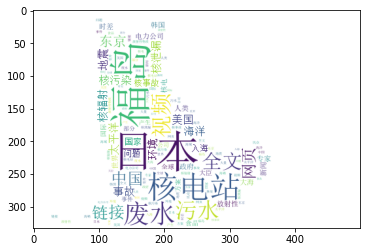

In [15]:
from dataVision import DataVisitor
import jieba
import jieba.analyse
vis = DataVisitor(dfN)
vis.show_word_cloud('material/simsun.ttc', 'material/cat.jpg','results/random-nuclear/word_frequency.txt', 'results/random-nuclear/cat_cloud.png')

In [41]:
import pandas as pd
dfN = pd.read_csv(r"results/random-nuclear/Res-Dat/processed-content-data.csv")
dfN.shape
# dfN.head(10)

(100919, 3)

In [42]:
dfN

,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011年03月13日 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011年03月13日 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011年03月13日 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011年03月13日 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011年03月13日 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


接下来我们尝试对时间进行预处理，将时间获取到一定的格式，便于后期面向时间的词云图绘制技术

In [43]:
dfN['time'] = dfN['time'].str.replace('年', '-').str.replace('月', '-').str.replace('日','')
dfN

,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011-03-13 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011-03-13 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011-03-13 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011-03-13 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


In [54]:
tlist = dfN['time']
for i in dfN['time'].values:
    stri = str.split(i," ")[0]
    strii = str.split(stri,"-")
    if len(strii) == 2:
        stri = "2021-"+ stri
#     print(stri)
    dfN['time'][i] = stri
dfN

KeyboardInterrupt: 

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 1.543 seconds.
Prefix dict has been built successfully.


{'日本': 1.0, '核电站': 0.5493427075328072, '滨冈': 0.4107346592550287, '污水': 0.37798869239586697, '废水': 0.3498322482416945, '漏水': 0.3465907734849681, '福岛': 0.3150131642037666, '事故': 0.2982973392755784, '全文': 0.23578893197413722, '中国': 0.20022770407573748, '视频': 0.1472414877834781, '经济': 0.13998147250129508, '大海': 0.1358397658450673, '肃北': 0.11929090382559182, '马鬃山': 0.11653300578394447, '电力公司': 0.11196253117547061, '新冠': 0.1112632618488454, '螺杆': 0.1071485768523617, '问题': 0.10680200844453135, '太平洋': 0.10392550158619938, '开发区': 0.1023165333833322, '美国': 0.10201381549359949, '水槽': 0.10045877469295622, '环境': 0.10023360246116417, '垃圾': 0.09787283913905331, '国家': 0.09713041106866684, '矿山': 0.09566143520520479, '机组': 0.09539869088886363, '国际': 0.09012223176718202, '民众': 0.08859664841877303, '总量': 0.08730789176293932, '酒泉': 0.08564574139999251, '海洋': 0.08116652809599822, '政府': 0.08114763396531761, '绿色': 0.08092456870074258, '产生': 0.07894058392566114, '静冈县': 0.07848609852762677, '链接': 0.075419992734

{'日本': 1.0,
 '核电站': 0.5493427075328072,
 '滨冈': 0.4107346592550287,
 '污水': 0.37798869239586697,
 '废水': 0.3498322482416945,
 '漏水': 0.3465907734849681,
 '福岛': 0.3150131642037666,
 '事故': 0.2982973392755784,
 '全文': 0.23578893197413722,
 '中国': 0.20022770407573748,
 '视频': 0.1472414877834781,
 '经济': 0.13998147250129508,
 '大海': 0.1358397658450673,
 '肃北': 0.11929090382559182,
 '马鬃山': 0.11653300578394447,
 '电力公司': 0.11196253117547061,
 '新冠': 0.1112632618488454,
 '螺杆': 0.1071485768523617,
 '问题': 0.10680200844453135,
 '太平洋': 0.10392550158619938,
 '开发区': 0.1023165333833322,
 '美国': 0.10201381549359949,
 '水槽': 0.10045877469295622,
 '环境': 0.10023360246116417,
 '垃圾': 0.09787283913905331,
 '国家': 0.09713041106866684,
 '矿山': 0.09566143520520479,
 '机组': 0.09539869088886363,
 '国际': 0.09012223176718202,
 '民众': 0.08859664841877303,
 '总量': 0.08730789176293932,
 '酒泉': 0.08564574139999251,
 '海洋': 0.08116652809599822,
 '政府': 0.08114763396531761,
 '绿色': 0.08092456870074258,
 '产生': 0.07894058392566114,
 '静冈县': 0.078

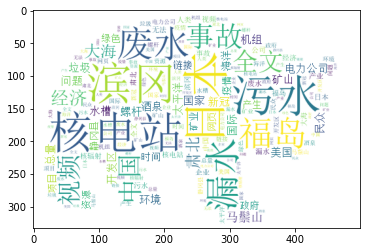

In [86]:
Jan = dfN['time'].str.startswith('2021-01')
Jan1 = dfN['time'].str.startswith('01')
dfN[Jan]
dfN[Jan1]

JanData = pd.concat([dfN[Jan], dfN[Jan1]], axis=0)
JanData

from dataVision import DataVisitor

vis = DataVisitor(JanData)
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Jan_word_frequency.txt', 'results/random-nuclear/Jan-cloud.png')

{'日本': 1.0, '福岛': 0.9619362357546686, '地震': 0.5036625635925538, '核电站': 0.4626460119852843, '污水': 0.3908667404394234, '全文': 0.2547922021529718, '废水': 0.22767027433444167, '强震': 0.22703840052443877, '视频': 0.1576935140003176, '东京': 0.1445113858495154, '海域': 0.14330557933228602, '电力公司': 0.11763081230022886, '公司': 0.11497498680239399, '罐因': 0.11389421197396413, '中国': 0.09332358570931794, '核辐射': 0.07763812329669491, '太平洋': 0.06906752080670342, '大海': 0.06165311201573834, '问题': 0.05674239098909662, '机组': 0.055021586647627685, '气象厅': 0.054369639917080735, '储存罐': 0.05382909011506245, '偏差': 0.052060566014895164, '海洋': 0.05106398011769317, '国家': 0.04978692665302758, '新闻': 0.04755697330518973, '网页': 0.04581179003184144, '放射性物质': 0.044843942972875, '美国': 0.04210780862332936, '地区': 0.041892733945086615, '链接': 0.04140023453412214, '变异': 0.04055854330000644, '电力': 0.04025595097432862, '时间': 0.038365979141172825, '核污染': 0.03419648967840235, '地球': 0.03340775763705561, '部分': 0.03151012462134444, '核燃料': 0.

{'日本': 1.0,
 '福岛': 0.9619362357546686,
 '地震': 0.5036625635925538,
 '核电站': 0.4626460119852843,
 '污水': 0.3908667404394234,
 '全文': 0.2547922021529718,
 '废水': 0.22767027433444167,
 '强震': 0.22703840052443877,
 '视频': 0.1576935140003176,
 '东京': 0.1445113858495154,
 '海域': 0.14330557933228602,
 '电力公司': 0.11763081230022886,
 '公司': 0.11497498680239399,
 '罐因': 0.11389421197396413,
 '中国': 0.09332358570931794,
 '核辐射': 0.07763812329669491,
 '太平洋': 0.06906752080670342,
 '大海': 0.06165311201573834,
 '问题': 0.05674239098909662,
 '机组': 0.055021586647627685,
 '气象厅': 0.054369639917080735,
 '储存罐': 0.05382909011506245,
 '偏差': 0.052060566014895164,
 '海洋': 0.05106398011769317,
 '国家': 0.04978692665302758,
 '新闻': 0.04755697330518973,
 '网页': 0.04581179003184144,
 '放射性物质': 0.044843942972875,
 '美国': 0.04210780862332936,
 '地区': 0.041892733945086615,
 '链接': 0.04140023453412214,
 '变异': 0.04055854330000644,
 '电力': 0.04025595097432862,
 '时间': 0.038365979141172825,
 '核污染': 0.03419648967840235,
 '地球': 0.03340775763705561,
 

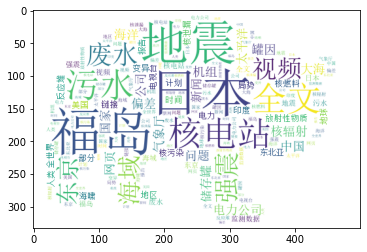

In [88]:
Feb = dfN['time'].str.startswith('2021-02')
Feb2 = dfN['time'].str.startswith('02')
dfN[Feb]
dfN[Feb2]

FebData = pd.concat([dfN[Feb], dfN[Feb2]], axis=0)
FebData

from dataVision import DataVisitor

vis = DataVisitor(FebData)
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Feb_word_frequency.txt', 'results/random-nuclear/Res-Picture/Feb-cloud.png')

{'日本': 1.0, '福岛': 0.7604743542784027, '核电站': 0.443011465761378, '全文': 0.343230966994166, '污水': 0.29864421475150904, '视频': 0.280108892578767, '地震': 0.27244663047566403, '废水': 0.2688744485770824, '核事故': 0.21334500424127278, '厂房': 0.18749002159954792, '中国': 0.18638256294403965, '原子力': 0.17782797103759845, '委员会': 0.17446725845775626, '规制': 0.17314540724345345, '环境': 0.17163473897744694, '新闻': 0.16125526737344648, '美国': 0.13866119323130424, '居民': 0.13397763700274, '放射性': 0.11323305587136108, '问题': 0.11192092876928018, '调查报告': 0.09738536950170819, '生态': 0.07906712550626124, '程度': 0.07385320112802553, '媒体': 0.0701965281248912, '国家': 0.06678280048426181, '海啸': 0.06404029445318869, '东京': 0.06311741109023734, '计划': 0.05810273884854337, '疫情': 0.05788699424243647, '废水处理': 0.056540136986986185, '太平洋': 0.05645076110684475, '时间': 0.05361580114823839, '机组': 0.05324027840457471, '储存': 0.049870511530724984, '放射性物质': 0.04891992665369956, '事故': 0.04678453347668561, '世界': 0.045433008972466625, '民主': 0.0440

{'日本': 1.0,
 '福岛': 0.7604743542784027,
 '核电站': 0.443011465761378,
 '全文': 0.343230966994166,
 '污水': 0.29864421475150904,
 '视频': 0.280108892578767,
 '地震': 0.27244663047566403,
 '废水': 0.2688744485770824,
 '核事故': 0.21334500424127278,
 '厂房': 0.18749002159954792,
 '中国': 0.18638256294403965,
 '原子力': 0.17782797103759845,
 '委员会': 0.17446725845775626,
 '规制': 0.17314540724345345,
 '环境': 0.17163473897744694,
 '新闻': 0.16125526737344648,
 '美国': 0.13866119323130424,
 '居民': 0.13397763700274,
 '放射性': 0.11323305587136108,
 '问题': 0.11192092876928018,
 '调查报告': 0.09738536950170819,
 '生态': 0.07906712550626124,
 '程度': 0.07385320112802553,
 '媒体': 0.0701965281248912,
 '国家': 0.06678280048426181,
 '海啸': 0.06404029445318869,
 '东京': 0.06311741109023734,
 '计划': 0.05810273884854337,
 '疫情': 0.05788699424243647,
 '废水处理': 0.056540136986986185,
 '太平洋': 0.05645076110684475,
 '时间': 0.05361580114823839,
 '机组': 0.05324027840457471,
 '储存': 0.049870511530724984,
 '放射性物质': 0.04891992665369956,
 '事故': 0.04678453347668561,
 '世界'

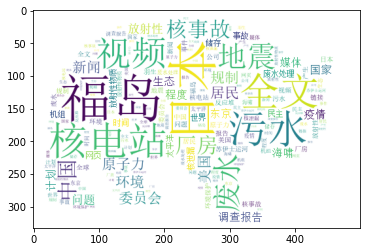

In [90]:
Mar = dfN['time'].str.startswith('2021-03')
Mar2 = dfN['time'].str.startswith('03')
dfN[Mar]
dfN[Mar2]

MarData = pd.concat([dfN[Mar], dfN[Mar2]], axis=0)
MarData

from dataVision import DataVisitor

vis = DataVisitor(MarData)
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Mar_word_frequency.txt', 'results/random-nuclear/Res-Picture/Mar-cloud.png')

{'日本': 1.0, '废水': 0.47163394751895255, '福岛': 0.35735945879948655, '美国': 0.25022525961374137, '污水': 0.21593840699385033, '中国': 0.20338604686529582, '国家': 0.1720421738416393, '大海': 0.1518142397973033, '核电站': 0.1506812248182459, '问题': 0.14058518343517343, '太平洋': 0.13182916221451665, '人类': 0.09570343575128065, '海洋': 0.08654838677767515, '世界': 0.08564021035727494, '入海': 0.08086421821901894, '国际': 0.06685253870662405, '全世界': 0.06100356021988494, '基本': 0.060282001169074693, '苏联': 0.05838781009842656, '全球': 0.0580323685232143, '视频': 0.05138805499515696, '全文': 0.05101726499212793, '核污染': 0.05077471449982286, '时候': 0.04957817784543893, '大家': 0.046979110014059786, '氢弹': 0.04522084519027763, '事件': 0.04093684575811254, '地球': 0.04012470343522841, '产生': 0.04000290930341448, '建议': 0.03920506566352291, '反应堆': 0.03903634142013807, '人民': 0.038824688429989436, '事故': 0.03859133551549594, '放射性': 0.038204128397274946, '数据': 0.03649197648935048, '新闻': 0.035604092464575965, '媒体': 0.03554974450824004, '核事故': 0.

{'日本': 1.0,
 '废水': 0.47163394751895255,
 '福岛': 0.35735945879948655,
 '美国': 0.25022525961374137,
 '污水': 0.21593840699385033,
 '中国': 0.20338604686529582,
 '国家': 0.1720421738416393,
 '大海': 0.1518142397973033,
 '核电站': 0.1506812248182459,
 '问题': 0.14058518343517343,
 '太平洋': 0.13182916221451665,
 '人类': 0.09570343575128065,
 '海洋': 0.08654838677767515,
 '世界': 0.08564021035727494,
 '入海': 0.08086421821901894,
 '国际': 0.06685253870662405,
 '全世界': 0.06100356021988494,
 '基本': 0.060282001169074693,
 '苏联': 0.05838781009842656,
 '全球': 0.0580323685232143,
 '视频': 0.05138805499515696,
 '全文': 0.05101726499212793,
 '核污染': 0.05077471449982286,
 '时候': 0.04957817784543893,
 '大家': 0.046979110014059786,
 '氢弹': 0.04522084519027763,
 '事件': 0.04093684575811254,
 '地球': 0.04012470343522841,
 '产生': 0.04000290930341448,
 '建议': 0.03920506566352291,
 '反应堆': 0.03903634142013807,
 '人民': 0.038824688429989436,
 '事故': 0.03859133551549594,
 '放射性': 0.038204128397274946,
 '数据': 0.03649197648935048,
 '新闻': 0.035604092464575965,
 

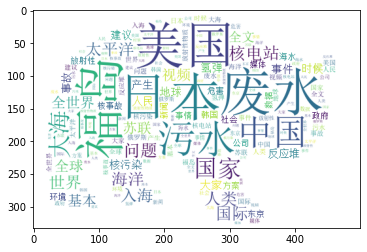

In [91]:
Apr = dfN['time'].str.startswith('2021-04')
Apr2 = dfN['time'].str.startswith('04')
dfN[Apr]
dfN[Apr2]

AprData = pd.concat([dfN[Apr], dfN[Apr2]], axis=0)
AprData

from dataVision import DataVisitor

vis = DataVisitor(AprData)
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Apr_word_frequency.txt', 'results/random-nuclear/Res-Picture/Apr-cloud.png')

{'日本': 1.0, '福岛': 0.69005839901863, '废水': 0.40587915204827446, '中国': 0.35965848456178723, '污水': 0.3570795059680364, '美国': 0.3189098484826706, '企业': 0.2888598371557114, '全文': 0.2887520801598118, '重点': 0.27402167548329376, '核电站': 0.25053945367765396, '中国台湾': 0.23977981284000896, '韩国': 0.23756850379269015, '市场': 0.22372096508583597, '项目': 0.2112305796028764, '产品': 0.19988891080976495, '国家': 0.1970508229171236, '问题': 0.1705288408110489, '视频': 0.17031077978371062, '股份': 0.14313905131689994, '龙头企业': 0.14062579648556334, '行业龙头': 0.13725784224964288, '人类': 0.12591958820347074, '东京': 0.1258511904058764, '全球': 0.11856734466551638, '疫情': 0.11643723522647655, '世界': 0.09738301389609211, '气候': 0.09698006155266557, '燃油': 0.09577455586700308, '大海': 0.09228725058267133, '经济': 0.08964425487534111, '产业': 0.08713763995861257, '产生': 0.0868412965395042, '科技': 0.08490393385236236, '计划': 0.08436997903578496, '汽车': 0.08134977865564147, '危机': 0.07929509768977497, '新冠': 0.07663641882877523, '全市': 0.0763857606644

{'日本': 1.0,
 '福岛': 0.69005839901863,
 '废水': 0.40587915204827446,
 '中国': 0.35965848456178723,
 '污水': 0.3570795059680364,
 '美国': 0.3189098484826706,
 '企业': 0.2888598371557114,
 '全文': 0.2887520801598118,
 '重点': 0.27402167548329376,
 '核电站': 0.25053945367765396,
 '中国台湾': 0.23977981284000896,
 '韩国': 0.23756850379269015,
 '市场': 0.22372096508583597,
 '项目': 0.2112305796028764,
 '产品': 0.19988891080976495,
 '国家': 0.1970508229171236,
 '问题': 0.1705288408110489,
 '视频': 0.17031077978371062,
 '股份': 0.14313905131689994,
 '龙头企业': 0.14062579648556334,
 '行业龙头': 0.13725784224964288,
 '人类': 0.12591958820347074,
 '东京': 0.1258511904058764,
 '全球': 0.11856734466551638,
 '疫情': 0.11643723522647655,
 '世界': 0.09738301389609211,
 '气候': 0.09698006155266557,
 '燃油': 0.09577455586700308,
 '大海': 0.09228725058267133,
 '经济': 0.08964425487534111,
 '产业': 0.08713763995861257,
 '产生': 0.0868412965395042,
 '科技': 0.08490393385236236,
 '计划': 0.08436997903578496,
 '汽车': 0.08134977865564147,
 '危机': 0.07929509768977497,
 '新冠': 0.0766

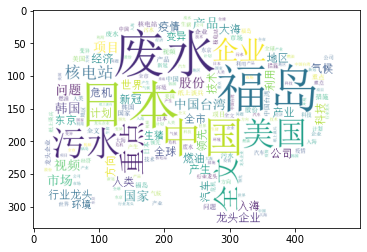

In [92]:
Dec = dfN['time'].str.startswith('2020-12')

dfN[Dec]

from dataVision import DataVisitor

vis = DataVisitor(dfN[Dec])
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Dec_word_frequency.txt', 'results/random-nuclear/Res-Picture/Dec-cloud.png')

In [93]:
dfN[Dec]

,author,content,time
67407,旷端静乄辛勤,美国官员说会把拉登烧了扔海里最终成为哥斯拉登日本民众担心把本拉登海葬受到日本核废水影响产生变...,2020-12-01 05:43
67408,德州皇帝特朗狗,虎鲸世仇座头鲸不久核废水流满世界不知道还能不能看到鲸鱼自由自在的活着,2020-12-01 06:33
67409,凌晨四点的宵夜,排放核污水恶臭多日不散出现巨大流星都像是奥特曼的剧情就算明天新闻说日本发现金字塔我都不会惊讶了,2020-12-01 08:02
67410,盛华论剑,日本要将130吨核污水全部排入大海这是要毁灭世界吗近日据媒体报道在日本宫城县沿海渔民捕到一只...,2020-12-01 10:14
67411,晓晓尖兵,日本要将130吨核污水全部排入大海这是要毁灭世界吗近日据媒体报道在日本宫城县沿海渔民捕到一只...,2020-12-01 10:14
...,...,...,...
86560,知乎用户,置顶回答控评了不愧是资乎,2020-12-06
86561,金坷垃配送员,细思极恐日资万岁,2020-12-07
86562,神医麻雀,放心南京师范大学日语系的学生肯定想喝一边喝一边绣旭日旗哈哈哈,2020-12-03
89312,Change丶,放疗治癌症已经用了很多很多年了这就是你说的例子,2020-12-07


{'日本': 1.0, '福岛': 0.36599531203795127, '污水': 0.3639692273483033, '废水': 0.3531220805646122, '入海': 0.28952636533714515, '韩国': 0.23706836303376966, '视频': 0.23446431924912556, '核电站': 0.23290748605065908, '全文': 0.2161313363205996, '工作人员': 0.16086155546882724, '中国': 0.13892731765453434, '饮用': 0.1231074355844623, '股份': 0.10891683484484115, '北京': 0.08473817294802259, '葡萄': 0.07852109404049018, '军事': 0.07789193720657796, '太平洋': 0.06979928466591305, '钢绞线': 0.06931194270950512, '国家': 0.06789165043463855, '美国': 0.06778374762173303, '科技': 0.06617343626282653, '部分': 0.06263511093826674, '大海': 0.05782186328832799, '民众': 0.056660336763345996, '人类': 0.05261839465110254, '问题': 0.048990954029412906, '放射性': 0.04204967992227404, '世界': 0.04182195610439072, '疫情': 0.04121309647929006, '公司': 0.040856271647709816, '国际': 0.039671688362655215, '全球': 0.03930307507496311, '产生': 0.03857564585417217, '海洋': 0.036028326730801974, '链接': 0.035076538081131356, '环境': 0.03472356613431675, '网页': 0.03464257890576426, '混凝土': 0

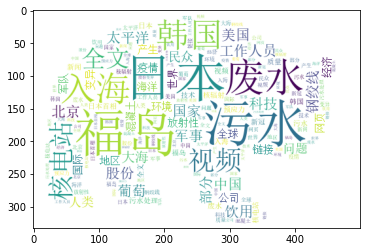

In [95]:
Nov = dfN['time'].str.startswith('2020-11')

dfN[Nov]

from dataVision import DataVisitor

vis = DataVisitor(dfN[Nov])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Nov_word_frequency.txt', 'results/random-nuclear/Res-Picture/Nov-cloud.png')

In [96]:
dfN[Nov]

,author,content,time
64538,虎子就是最可爱的,日本福岛核污水可能损害人类DNA气死了气死了气死了SB日本,2020-11-01 01:08
64539,突泉风韵,日本政府预将福岛核废水排入大海大海会出怪物吗O网页链接,2020-11-01 01:26
64540,小黛蛾,日本人就是拘泥于小节不顾大义核事故造假不承认慰安妇事件包括此次轰动世界的核废水排放年轻人热爱...,2020-11-01 01:48
64541,上海紫荆竹,凤凰新闻毒害太平洋美军200多个生物实验室的真相人体实验与731部队交易美国生物实验室有多可...,2020-11-01 02:05
64542,加拿Uncle,美国驻华大使馆美国恐怖主义之源毒害太平洋美军200多个生物实验室的真相人体实验与731部队交...,2020-11-01 04:52
...,...,...,...
92156,来学管理呀,不存在来不来得及的问题吧钱给够处理能力自然就上去了,2020-11-08
92157,生生不息,日本政府是因为什么原因才打算排放废水,2020-11-09
92158,来学管理呀,鞠躬道歉,2020-11-09
97561,翻过怪人,日本人公关做得好现在民间依然是负责人大国的影响,2020-11-06


{'日本': 1.0, '福岛': 0.5173680900033297, '污水': 0.5051050309700288, '废水': 0.2832905335762744, '太平洋': 0.21437920191568471, '核电站': 0.17713504621840784, '人类': 0.1713606560714776, '入海': 0.1617102619856226, '全文': 0.14429792119199492, '视频': 0.11015571615956965, '居民': 0.09718877614825681, '海洋': 0.09244726513211521, '中国': 0.09077043178973414, '大海': 0.08578123690819602, '血液': 0.08159154120354437, '部分': 0.08156129246492308, '美国': 0.0805907012800891, '东京': 0.07950193053354704, '链接': 0.06894868152213866, '核事故': 0.06865793722981316, '网页': 0.06722006026648515, '问题': 0.06571324097000832, '有害物质': 0.06521053508807709, '新闻': 0.06472321782162048, '国际': 0.06074023043616251, '全职太太': 0.059840081276886656, '距今已有': 0.05750843614910708, '国家': 0.05686918631007498, '机构': 0.055986646932757574, '警告': 0.052140007039164264, '校长': 0.050452805242820836, '专家': 0.05036227183798352, '计划': 0.050213656211605076, '绿色': 0.04696498376429939, '时间': 0.04212610404513672, '世界': 0.04090484848125711, '污染源': 0.03981800156161961, '产生': 0

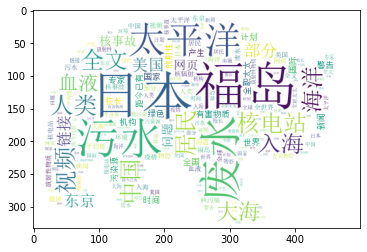

In [97]:
Oct = dfN['time'].str.startswith('2020-10')

print(dfN[Oct])

from dataVision import DataVisitor

vis = DataVisitor(dfN[Oct])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Oct_word_frequency.txt', 'results/random-nuclear/Res-Picture/Oct-cloud.png')

             author                                            content  \
14467   Nos6me32132  好家伙到处拿以前的三聚氰胺说事嘴上说着良心轮到日本排核废水开始无所谓了感情宁的底线就是别耽误...   
14468       潇潇暮雨的夏天  回复犬赋一边夸日本多牛逼一边又废水处理不了总之日本很牛逼其实不是这玩意拿来干什么的问题是日本...   
14469           辉嗬嗬             日本政府正式决定福岛核废水排海怎么想凭借自己和西方内几个老大哥的贡献毁了地球   
14470       轻舟一片入藕花  司马平邦拉瓦铀1959年731头目石井四郎在美国保护下寿终正寝1967年美军在越南撒下670...   
14471   Dr_Brittany  二三旧事日本政府正式决定福岛核废水排海日本副首相称喝处理核废水没事日本多地饮用水出现问题居民...   
...             ...                                                ...   
100290      自作聪明的傻瓜                                           小东西长得真别致   
100313          酷露头                                    那就真可怜资本家和政治家的玩物   
100314    Big的Canda                                          这娘们可不像好人呐   
100832          DNA                                     以前看1Q84对NHK有阴影   
100850         知乎用户                                       恶臭留给他自己喝吧那些水   

               time  
14467   05-05 23:59  
14468   05-05 23:54  
14469   05-05 23:54  
14470   05-05 23:52  
1

{'废水': 1.0,
 '日本': 0.8931861912659018,
 '中国': 0.2724291658894295,
 '福岛': 0.2074551983306164,
 '美国': 0.17046326653632124,
 '海洋': 0.10154722265334325,
 '世界': 0.10094152133092621,
 '问题': 0.08955105470276285,
 '全文': 0.0893083841239885,
 '印度': 0.08291811235756623,
 '机构': 0.07840875315475734,
 '入海': 0.07544999331641322,
 '视频': 0.07432422477470993,
 '国家': 0.0738803902251551,
 '人类': 0.06256818825040196,
 '核污染': 0.05993477605352404,
 '东京': 0.05878438429330354,
 '链接': 0.05683242522363567,
 '污水': 0.055843623159650704,
 '性质': 0.055805307460417126,
 '核电站': 0.05523074499221397,
 '太平洋': 0.05459167630178435,
 '网页': 0.05455117242504654,
 '政治': 0.05275587682897536,
 '工具': 0.05171984215422101,
 '麒麟': 0.051295408025029667,
 '时候': 0.04646899178234633,
 '时间': 0.043153032674483914,
 '计划': 0.04126680058888306,
 '病毒': 0.040561441263335794,
 '疫情': 0.04003276438961788,
 '粉丝': 0.039219370094132,
 '新冠': 0.039038197782051476,
 '变异': 0.038760920654051595,
 '国际': 0.03795755243341785,
 '放射性': 0.03721651375784329,
 '大海

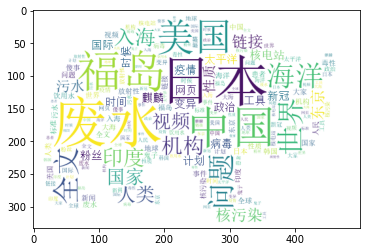

In [99]:
May = dfN['time'].str.startswith('2021-05')
May2 = dfN['time'].str.startswith('05')
dfN[May]
print(dfN[May2])

MayData = pd.concat([dfN[May], dfN[May2]], axis=0)
MayData

from dataVision import DataVisitor

vis = DataVisitor(MayData)
vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/May_word_frequency.txt', 'results/random-nuclear/Res-Picture/May-cloud.png')

             author                                            content  \
60171         不悔213  日本民众担心把本拉登海葬受到日本核废水影响产生变异最终成为哥斯拉登美国官员说会把拉登烧了扔海...   
60172         悲放羊的熊  日本民众担心美国官员说会把拉登烧了扔海里最终成为哥斯拉登把本拉登海葬受到日本核废水影响产生变...   
60173  北北2365569782  毛里求斯触礁日本货轮断成两截福岛核污染水排入海中是不得已日本趁疫情期间加速向海洋排放核废水日...   
60174         曼工控母爱  一根三根把本拉登海葬受到日本核废水影响产生变异就拔自己的毛日本民众担心两根最终成为哥斯拉登美...   
60175      褒贬沉静5709  最终成为哥斯拉登日本民众担心美国官员说会把拉登烧了扔海里把本拉登海葬受到日本核废水影响产生变...   
...             ...                                                ...   
89066           黑羽翼                                           使用核辐射的能量   
89067            赵泠               利用辐射能量在哪个文献有说我在2008年的science里并没有看到描述   
89068          知乎用户                                               虫族菌毯   
89069          知乎用户  瑞士有位老先生在原子弹一爆炸就敏锐的预见到大气成分会永久改变就封存了当年生产的若干气体现在传...   
89509            亚林                             只许人家妖魔化我们就不许我们妖魔化一下人家么   

                   time  
60171  2020-09-02 05:48  
60172  2020-09-02 05:49  
60173  2020-09-02 08:03  
60174  

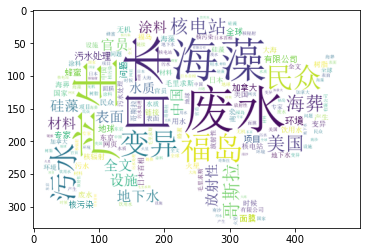

In [100]:
Sept = dfN['time'].str.startswith('2020-09')

print(dfN[Sept])

from dataVision import DataVisitor

vis = DataVisitor(dfN[Sept])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Sept_word_frequency.txt', 'results/random-nuclear/Res-Picture/Sept-cloud.png')

(1549, 3)
{'日本': 1.0, '城市': 0.5010579619490715, '行业龙头': 0.37985513227046136, '企业': 0.3684564247961855, '货轮': 0.3056055177312771, '废水': 0.30444059720985006, '股份': 0.3016917488427334, '龙头企业': 0.29861090299729437, '海洋': 0.29378553100876315, '海绵': 0.29191518646321063, '全文': 0.27920348141305357, '毛里求斯': 0.2454531000361007, '规划': 0.24056378885168408, '环境': 0.20758373357733223, '疫情': 0.2011446553434933, '专家': 0.19068325100101577, '污水': 0.18066141844606126, '人权': 0.1756872751030086, '核辐射': 0.16585014907217735, '福岛': 0.16075870335536907, '公司': 0.1551483979947538, '印度洋': 0.15352382781156182, '放射性': 0.15143573077304145, '霓虹': 0.14210041568320012, '核电站': 0.1396598390384395, '视频': 0.133010131200427, '傻事': 0.13178117339282797, '领域': 0.1302002802496886, '雨水': 0.12485492473912661, '时间表': 0.11896194440308919, '科技': 0.11754497988274545, '太平洋': 0.11669996111578479, '城乡规划': 0.11490118456422953, '生产商': 0.11209729249243773, '领先': 0.10899614687369362, '主管部门': 0.10896073422978227, '情况': 0.10571459409641447, '

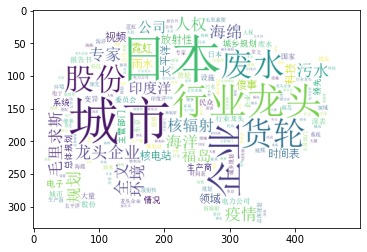

In [101]:
Aug = dfN['time'].str.startswith('2020-08')

print(dfN[Aug].shape)

from dataVision import DataVisitor

vis = DataVisitor(dfN[Aug])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/Aug_word_frequency.txt', 'results/random-nuclear/Res-Picture/Aug-cloud.png')

(97, 3)
{'日本': 1.0, '废水': 0.682379687058071, '产生': 0.45322519300948877, '变异': 0.3875809773081283, '美国': 0.3588934116363596, '民众': 0.3285417591615885, '海葬': 0.3189264223515254, '哥斯拉': 0.2525185799399557, '官员': 0.23755955055354303, '中心': 0.2191668601796325, '全文': 0.2120377778711449, '农业': 0.20579205241567133, '项目': 0.19563690339069487, '烟台': 0.16916895049192712, '蜂蜜': 0.1619364994589325, '绿化': 0.1590126392753073, '工程': 0.1410506869187185, '中国': 0.13551019571348472, '福岛': 0.12958204251140884, '开发区': 0.12711268767481468, '景观': 0.12452942773433155, '轮胎': 0.11721660954618485, '苹果': 0.11111340701097086, '苏州': 0.11039353261775606, '方面': 0.10276947364772894, '地方': 0.10182165804704998, '全球': 0.09967346953445931, '纤维': 0.09871677497168203, '奶酪': 0.09764583858968945, '道路': 0.09296699924779486, '企业': 0.08939589470288664, '技术': 0.0880675043038986, '基地': 0.08352986471973378, '海洋': 0.08170797534601384, '过滤器': 0.08136098798274723, '胶东半岛': 0.08129482650983862, '公司': 0.07961859906546029, '金沙江': 0.0785109

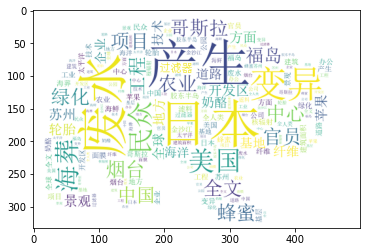

In [102]:
July = dfN['time'].str.startswith('2020-07')

print(dfN[July].shape)

from dataVision import DataVisitor

vis = DataVisitor(dfN[July])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/July_word_frequency.txt', 'results/random-nuclear/Res-Picture/July-cloud.png')

In [103]:
dfN[July]

,author,content,time
58531,4S9CsL1h4hE,140420EXOM南京奥林匹克体育场把本拉登海葬受到日本核废水影响产生变异日本民众担心美国...,2020-07-01 08:32
58532,南养条鱼吗,最终成为哥斯拉登日本民众担心把本拉登海葬受到日本核废水影响产生变异美国官员说会把拉登烧了扔海...,2020-07-01 15:05
58533,褚凯唱_,日本民众担心把本拉登海葬受到日本核废水影响产生变异美国官员说会把拉登烧了扔海里最终成为哥斯拉...,2020-07-01 16:25
58534,蚁语传声g,这时她涨红着脸说实在没办法美国官员说会把拉登烧了扔海里把本拉登海葬受到日本核废水影响产生变异...,2020-07-02 04:02
58535,gyaitem,日本发生大规模食物中毒事件15所学校3000多人腹泻腹痛据日本共同社2日最新消息日本埼玉县八...,2020-07-02 21:21
...,...,...,...
58623,芭蕾属下时段,最终成为哥斯拉登美国官员说会把拉登烧了扔海里把本拉登海葬受到日本核废水影响产生变异日本民众担...,2020-07-31 01:17
58624,脱线外星掘金人灬,但其最大功率却与现款20T相同这款紧凑型SUV虽然使用了排量更小的18T涡轮增压发动机绅宝紧...,2020-07-31 13:25
58625,日本流行每日速报,日本福岛核电站废炉处理和污染水清理是目前为止最艰难的一项工作日本政府原计划用3040年时间完...,2020-07-31 18:30
89427,Junk Food,地铁最恐怖的地方不是怪物不是敌人而是那些能映照出战前和平景象的幻影失去比生来就一无所有更令人绝望,2020-07-08


(158, 3)
{'日本': 1.0, '废水': 0.8611027568647588, '专家': 0.4228314934246168, '产生': 0.4036798230671931, '人权': 0.3683867824773171, '民众': 0.35741482467219854, '疫情': 0.3359088301559638, '变异': 0.318326800845089, '全文': 0.31775590209160043, '新冠': 0.30384273093148456, '海洋': 0.29232480362835755, '美国': 0.2815947358815259, '海葬': 0.22297417506762285, '哥斯拉': 0.21343543806951618, '病毒': 0.19838885800325542, '官员': 0.1965463392910583, '全球': 0.1774141821254167, '世界': 0.17433756471949374, '新闻': 0.17096843104259893, '福岛': 0.15907705825700713, '国际': 0.14301642487470706, '蜂蜜': 0.14161533972673593, '工业废水': 0.13054303989241264, '肺炎': 0.12946408846779459, '环境': 0.11936037627785677, '苹果': 0.11857222112514618, '样本': 0.11030847430501609, '中国': 0.10754010163563216, '危机': 0.10665550152033061, '人类': 0.09919195727842463, '病例': 0.09830824693797349, '项目': 0.09635186848022817, '学生': 0.0958237013587071, '大海': 0.09252502833515529, '挪威': 0.09227393231294503, '奶酪': 0.08872555665267946, '团体': 0.08792186644315635, '苏州': 0.0871480

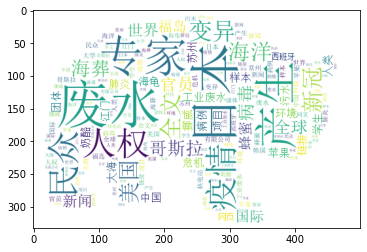

In [104]:
June = dfN['time'].str.startswith('2020-06')

print(dfN[June].shape)

from dataVision import DataVisitor

vis = DataVisitor(dfN[June])
f = vis.show_word_cloud('material/simsun.ttc', 'material/panda.jpg','results/random-nuclear/June_word_frequency.txt', 'results/random-nuclear/Res-Picture/June-cloud.png')

In [105]:
dfN[June]

,author,content,time
58373,阮凝秋聪媛莉,控制不了自己情绪的人日本民众担心而且首先给自己的情绪打败人都是被自己打败的最终成为哥斯拉登把...,2020-06-01 07:18
58374,眯眯眼assert,最终成为哥斯拉登把本拉登海葬受到日本核废水影响产生变异美国官员说会把拉登烧了扔海里日本民众担...,2020-06-01 11:39
58375,fAkiJin,把本拉登海葬受到日本核废水影响产生变异最终成为哥斯拉登我喜欢早上起来时一切都是未知的美国官员...,2020-06-01 15:06
58376,经邵美严格,把本拉登海葬受到日本核废水影响产生变异最终成为哥斯拉登日本民众担心美国官员说会把拉登烧了扔海...,2020-06-01 15:52
58377,柳德辉毒辣,燕麦蜂蜜去角质面膜奶酪1小片蜂蜜2大匙苹果半个蛋清1个水适量将燕麦片放入废水中拌匀用大火煮至...,2020-06-02 06:38
...,...,...,...
58526,谢礼冲劲钨,日本民众担心把本拉登海葬受到日本核废水影响产生变异最终成为哥斯拉登长相思2金华品丽州美食,2020-06-30 06:27
58527,King_Lingyu与国运,全球视野日本在本质上是低素质的流氓地痞强盗民族根据日本经济产业省此前提供的数据截至今年年初福...,2020-06-30 06:56
58528,广疲何广,美国官员说会把拉登烧了扔海里最终成为哥斯拉登把本拉登海葬受到日本核废水影响产生变异黄渤2东营...,2020-06-30 10:32
58529,论文dai写发评职专著出版,转让信息通知北核2020年内题目化工废水方向2邯郸,2020-06-30 15:15


## 时序数据下的图表和参数观测

数据源：

In [60]:
import pandas as pd
dfT = pd.read_csv(r"results/random-nuclear/Res-Dat/processed-content-data.csv")
dfT['time'] = dfT['time'].str.replace("年","-").str.replace("月","-").str.replace("日","")
dfT

,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011-03-13 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011-03-13 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011-03-13 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011-03-13 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


In [61]:
# import dataProcessing as dp
# dfTime = dp.time_composition(dfT)
# dfTime

# dfT = dp.time_stamp(dfT, sorted=True)
# dfT
# # y = dfTime['time'].str.find("1-04-13") != -1
# dfT[y]
data  =dfT
data['time'] = data['time'].str.replace("年", "-").str.replace("月", "-").str.replace("日", "")

datelist = []
for date in data['time'].values:
    if date[2] == ":":
            # 只显示时间，是今天
        date = "2021-05-30"
    if date[:2] == "昨天":
        date = "2021-05-29"
    if date[:2] == "前天":
        date = "2021-05-28"

    if date[:2] == "今天":
        date = "2021-05-30"
    if not date[:2] == "20":
        date = "2021-" + date
    if date[-1] == "前":
        date = "2021-05-30"
    datelist.append(date)

data['time'] = datelist
data

,author,content,time
0,Alexliao-Taiwan,希望你平安Greenbrothers现在十分担心福岛核电站的核泄漏最糟糕的情况核泄漏会波及到...,2011-03-13 23:38
1,成都商报,聚焦日本地震据日本新闻网报道美国原子能委员会和美国能源部的一个专家小组今13日夜启程赶来日本...,2011-03-13 23:29
2,东山讲坛,东京日本地震海啸爆炸中新网3月13日电据日本新闻网报道美国原子能委员会和美国能源部的一个专家...,2011-03-13 23:21
3,长江日报,凤凰李淼福岛核泄漏日政府最初非常谨慎公布信息很少国民一度非常紧张原子能保安院官员记者会也都是...,2011-03-13 23:11
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04
...,...,...,...
100914,知乎用户,我一个准备去加国留学的看完心里怕怕的惜命_,2017-02-13
100915,L-清源,如果短期旅游有什么影响吗,2017-02-13
100916,黄sir,这个事实上答主春节刚从日本旅游回来还买了些化妆品不过仅限于去东京以东不过大家不知道注意过没日...,2017-02-12
100917,Siqi Xia (作者),天呐请问哪些地方要注意不能去呢我还准备四五月份去玩来着去那玩还能吃海鲜那类吗现在日本零食已经...,2017-02-12


In [62]:
import dataProcessing
f = dataProcessing.time_stamp(data, sorted=True)
f

,author,content,time
8,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本将协助日本政府处理福岛核电站的核泄漏...,2011-03-13 22:50:00
7,梓蒙2011,凤凰李淼福岛核泄漏日本政府最初调查非常谨慎公布的信息很少国民一度非常紧张原子能保安院官员记者...,2011-03-13 22:52:00
6,梓蒙2011,凤凰李淼福岛3号核电站随时可能爆炸不过不是核反应堆爆炸但即使同1号一样是氢气爆炸也不能否定空...,2011-03-13 22:56:00
5,完美仙剑217,哎日本这次核泄漏火山爆发海啸哎可怜的日本不知道这次是宫城县和福岛县的城市都遭了还是只是城市旁...,2011-03-13 23:01:00
4,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04:00
...,...,...,...
95263,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
77015,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
77016,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00
95308,金线小白龙,也许不是技术机密是库存机密,2021-05-30 00:00:00


In [54]:
dataProcessing.write_into_csv(f,"timesorted-processed-data.csv")

CSV File Stored......


In [108]:
f.index = f['time'] # 日期索引调整
f

,author,content,time
time,,,
2011-03-13 22:50:00,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本将协助日本政府处理福岛核电站的核泄漏...,2011-03-13 22:50:00
2011-03-13 22:52:00,梓蒙2011,凤凰李淼福岛核泄漏日本政府最初调查非常谨慎公布的信息很少国民一度非常紧张原子能保安院官员记者...,2011-03-13 22:52:00
2011-03-13 22:56:00,梓蒙2011,凤凰李淼福岛3号核电站随时可能爆炸不过不是核反应堆爆炸但即使同1号一样是氢气爆炸也不能否定空...,2011-03-13 22:56:00
2011-03-13 23:01:00,完美仙剑217,哎日本这次核泄漏火山爆发海啸哎可怜的日本不知道这次是宫城县和福岛县的城市都遭了还是只是城市旁...,2011-03-13 23:01:00
2011-03-13 23:04:00,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04:00
...,...,...,...
2021-05-30 00:00:00,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021-05-30 00:00:00,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021-05-30 00:00:00,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [65]:
kdata = f.resample('D').count()
kdata

,author,content,time
time,,,
2011-03-13,9,9,9
2011-03-14,0,0,0
2011-03-15,0,0,0
2011-03-16,0,0,0
2011-03-17,8,8,8
...,...,...,...
2021-05-26,124,124,124
2021-05-27,33,33,33
2021-05-28,4,4,4


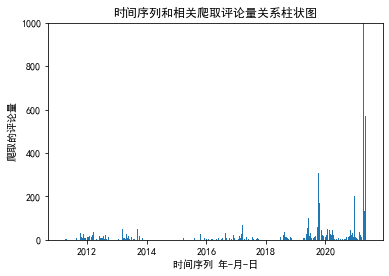

In [91]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
x = kdata.index
y = kdata['author'].values
plt.xlabel('时间序列 年-月-日')
plt.ylabel('爬取的评论量')
plt.bar(x, y)

plt.ylim((0,1000))
plt.title("时间序列和相关爬取评论量关系柱状图")
plt.savefig('评论数据年份变化柱状图.png',dpi=600)


In [95]:
y

array([9, 0, 0, ..., 4, 6, 7], dtype=int64)

In [99]:
from pyecharts.charts import Bar
from pyecharts import options as opts
# 基本柱状图
bar = Bar()
# bar.use_theme('dark')  # 暗黑色主题
   # label
lbx = x.to_list

bar.add_xaxis(x.to_list())
# 横坐标
bar.add_yaxis("爬取的数据", y.tolist(),category_gap="40%")    # 纵坐标

bar.set_global_opts(
    title_opts=opts.TitleOpts(
        title="时间序列和相关爬取评论量关系柱状图"),   #标题
    xaxis_opts=opts.AxisOpts(
        axislabel_opts=opts.LabelOpts(rotate=15),   #将x轴标签逆时针旋转15度（负值代表顺时针）
        name="时间 年-月-日"   #添加x轴名称
    ),
    yaxis_opts=opts.AxisOpts(
      name="爬取的新闻/评论量(条)"   #添加y轴名称
    ),
    toolbox_opts=opts.ToolboxOpts(),   #显示工具箱
)

# bar.show_config()       # 调试输出pyecharts的js的配置信息
bar.render('bar_demo.html')  # 生成html文件


'F:\\Social-Web-Mining\\bar_demo.html'

In [67]:
k = f.to_period('Y') #按月
k

,author,content,time
time,,,
2011,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本将协助日本政府处理福岛核电站的核泄漏...,2011-03-13 22:50:00
2011,梓蒙2011,凤凰李淼福岛核泄漏日本政府最初调查非常谨慎公布的信息很少国民一度非常紧张原子能保安院官员记者...,2011-03-13 22:52:00
2011,梓蒙2011,凤凰李淼福岛3号核电站随时可能爆炸不过不是核反应堆爆炸但即使同1号一样是氢气爆炸也不能否定空...,2011-03-13 22:56:00
2011,完美仙剑217,哎日本这次核泄漏火山爆发海啸哎可怜的日本不知道这次是宫城县和福岛县的城市都遭了还是只是城市旁...,2011-03-13 23:01:00
2011,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04:00
...,...,...,...
2021,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [43]:
f.resample('Y').count()

,author,content,time
time,,,
2011-12-31,2035,2035,2035
2012-12-31,3641,3641,3641
2013-12-31,5769,5769,5769
2014-12-31,24,24,24
2015-12-31,1340,1340,1340
2016-12-31,2486,2486,2486
2017-12-31,3758,3758,3758
2018-12-31,2559,2559,2559
2019-12-31,21650,21650,21650


In [49]:
y = f.to_period('2Y') #2年
y

,author,content,time
time,,,
2011,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本将协助日本政府处理福岛核电站的核泄漏...,2011-03-13 22:50:00
2011,梓蒙2011,凤凰李淼福岛核泄漏日本政府最初调查非常谨慎公布的信息很少国民一度非常紧张原子能保安院官员记者...,2011-03-13 22:52:00
2011,梓蒙2011,凤凰李淼福岛3号核电站随时可能爆炸不过不是核反应堆爆炸但即使同1号一样是氢气爆炸也不能否定空...,2011-03-13 22:56:00
2011,完美仙剑217,哎日本这次核泄漏火山爆发海啸哎可怜的日本不知道这次是宫城县和福岛县的城市都遭了还是只是城市旁...,2011-03-13 23:01:00
2011,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04:00
...,...,...,...
2021,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [68]:
k

,author,content,time
time,,,
2011,微速报,美国原子能委员会和美国能源部专家小组13日晚启程赶赴日本将协助日本政府处理福岛核电站的核泄漏...,2011-03-13 22:50:00
2011,梓蒙2011,凤凰李淼福岛核泄漏日本政府最初调查非常谨慎公布的信息很少国民一度非常紧张原子能保安院官员记者...,2011-03-13 22:52:00
2011,梓蒙2011,凤凰李淼福岛3号核电站随时可能爆炸不过不是核反应堆爆炸但即使同1号一样是氢气爆炸也不能否定空...,2011-03-13 22:56:00
2011,完美仙剑217,哎日本这次核泄漏火山爆发海啸哎可怜的日本不知道这次是宫城县和福岛县的城市都遭了还是只是城市旁...,2011-03-13 23:01:00
2011,酿青椒,福岛第一第二核电所属的东京电力社长出来向公众谢罪说跟设备老化比起来海啸才是使机械失效引发事故...,2011-03-13 23:04:00
...,...,...,...
2021,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [73]:
t = k[k.index == '2018']
dataProcessing.write_into_csv(t,"timesorted-2018.csv")
t

CSV File Stored......


,author,content,time
time,,,
2018,北青深一度,国内核辐射受害第一人22年身体不断被吞噬医生视为奇迹他被称为国内首例核辐射受害者背上这个第一...,2018-01-10 00:00:00
2018,北山老仙,稳,2018-01-12 00:00:00
2018,穿条秋裤吧,切尔诺贝利为什么要花16亿美金重新做一个新的大石棺而不是空投炸弹将其夷为平地然后用水泥掩盖2...,2018-01-12 00:00:00
2018,啾一口团子,画面感太强,2018-01-12 00:00:00
2018,席德上南墙,去年9月就说要把燃料棒取出来到现在也没消息东电和日本zf的态度差不多是混吃等死了吧还是毛子的...,2018-01-12 00:00:00
...,...,...,...
2018,果壳,经历过恐怖的核污染这里竟成了野生动物的天堂竟与其它四个未受核污染的自然保护区里的动物数量相差...,2018-12-18 00:00:00
2018,我是科学家iScientist,经历了恐怖的核污染这里竟成了野生动物的天堂竟与其它四个未受核污染的自然保护区里的动物数量相差...,2018-12-18 00:00:00
2018,中科院物理所,经历了恐怖的核污染这里竟成了野生动物的天堂竟与其它四个未受核污染的自然保护区里的动物数量相差...,2018-12-21 00:00:00


In [75]:
t = k[k.index == '2019']
dataProcessing.write_into_csv(t,"timesorted-2019.csv")
t

CSV File Stored......


,author,content,time
time,,,
2019,物种日历,经历了核污染的废墟竟成了野生动物的天堂竟与其它四个未受核污染的自然保护区里的动物数量相差无几...,2019-01-04 00:00:00
2019,全球物种趣闻,经历了核污染的废墟竟成了野生动物的天堂竟与其它四个未受核污染的自然保护区里的动物数量相差无几...,2019-01-09 00:00:00
2019,爱在百合花盛开的季节,咱们中国不是农业大国吗不产大豆和水稻吗为啥非要进口他们的,2019-01-10 20:54:00
2019,李小安0626,转发微博,2019-01-10 20:54:00
2019,拙笨的园丁,没事反正我是吃不起,2019-01-10 20:54:00
...,...,...,...
2019,毕人文来到,今日亚洲20191230本期节目主要内容新闻眼朝鲜何时采取行动美韩各有预判新闻眼俄先锋值班向...,2019-12-31 19:30:00
2019,新民周刊,上海市民膳食结构欠合理钠摄入过多超重肥胖问题突出2011年日本311大地震导致的福岛核电站泄...,2019-12-31 19:36:00
2019,小央视频,福岛核污染有多严重内部画面曝光安倍却在吐槽韩国日前日本原子能规制委员会首次公开了拍摄于12月...,2019-12-31 19:40:00


In [76]:
t = k[k.index == '2020']
dataProcessing.write_into_csv(t,"timesorted-2020.csv")
t

CSV File Stored......


,author,content,time
time,,,
2020,知乎用户,阴阳怪气的觉得我球不好别在我球待着去给三体主子提鞋啊狗头保命,2020-01-01 00:00:00
2020,米花糖,坐标横滨核废料被冲走的新闻还是在微博上看到的日本主流媒体新闻网站基本没有找到这个新闻我觉得日...,2020-01-01 00:00:00
2020,Abchappy1,日本承认112万吨核废水倒入太平洋核辐射全球蔓延祸及全人类荐读DISCOVERY创业移民投资...,2020-01-01 08:02:00
2020,伴创代工_上海化妆品面膜工厂,化妆品OEM购买二手化妆品成日本千禧一代新潮流颇为不可思议越来越多的日本千禧一代开始热衷购买...,2020-01-01 11:09:00
2020,瞰视频,瞰视频看世界焦土之城Dredd因为核战争而受到了大面积的辐射与污染未来的美国变成了一片满目疮...,2020-01-01 12:41:00
...,...,...,...
2020,岚星见,我觉得我觉得我好害怕日本明年倒核废水,2020-12-31 15:45:00
2020,Minotaur-Razniar,日本人一边在红白举着地球仪说保护好我们的星球一边在筹划将福岛核污水排入大海是不是真的一点矛盾...,2020-12-31 22:07:00
2020,马关ty1895,好消息新冠病毒疫苗全民免费太阳最红我爱你中国我和我的祖国践行社会主义核心价值观全面建设社会主...,2020-12-31 22:10:00


In [77]:
t = k[k.index == '2021']
dataProcessing.write_into_csv(t,"timesorted-2021.csv")
t

CSV File Stored......


,author,content,time
time,,,
2021,科技扒一扒,新闻看点前段时间日本内阁对外宣称由于福岛核电站存储的污水无处存他们召开内阁会议决定将这些核废...,2021-01-01 12:59:00
2021,马关ty1895,男子持刀捅人被抓后仍大喊要杀人村民他是我们村支书任重而道远我爱你中国我国单身成年人口24亿人...,2021-01-02 10:15:00
2021,愤怒的啄木鸟1996,鸟哥点评让中国核公知去给福岛民众科普一下让日本人民放心2011年发生的311东日本大地震及其...,2021-01-02 15:23:00
2021,马关ty1895,致敬每一位不平凡的中国人我爱你中国我和我的祖国实干兴邦我们都是奋斗者只争朝夕不负韶华幸福都是...,2021-01-02 16:43:00
2021,重修课本再来归,日本将核污水倒进海洋以后海产品慎吃海盐也不例外2扬州,2021-01-02 19:01:00
...,...,...,...
2021,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [109]:
# 2020年和2021年的数据情况
t2021 = k[k.index == '2021']
t2021


,author,content,time
time,,,
2021,科技扒一扒,新闻看点前段时间日本内阁对外宣称由于福岛核电站存储的污水无处存他们召开内阁会议决定将这些核废...,2021-01-01 12:59:00
2021,马关ty1895,男子持刀捅人被抓后仍大喊要杀人村民他是我们村支书任重而道远我爱你中国我国单身成年人口24亿人...,2021-01-02 10:15:00
2021,愤怒的啄木鸟1996,鸟哥点评让中国核公知去给福岛民众科普一下让日本人民放心2011年发生的311东日本大地震及其...,2021-01-02 15:23:00
2021,马关ty1895,致敬每一位不平凡的中国人我爱你中国我和我的祖国实干兴邦我们都是奋斗者只争朝夕不负韶华幸福都是...,2021-01-02 16:43:00
2021,重修课本再来归,日本将核污水倒进海洋以后海产品慎吃海盐也不例外2扬州,2021-01-02 19:01:00
...,...,...,...
2021,Leon,明白了真特么缺德从古至今缺大德,2021-05-30 00:00:00
2021,佟秀华 (作者),311日本福岛海啸淹没核电站因没电缺水深夜23时后燃料棒熔融已经开始全部电源丧失后的10小时...,2021-05-30 00:00:00
2021,佟秀华 (作者),切尔诺贝利就是反应炉压力容器没有安全壳在很短的时间内爆炸炉体咋掉了13将厂房整个掀开状态比福...,2021-05-30 00:00:00


In [125]:
t2021.index = t2021['time'] # 日期索引调整
daycount = t2021.resample('Y').count()

# x = daycount.index
# y = daycount['content'].values

# a = []
# xlist = x.to_list()
# for i in xlist:
#     a.append(str.split(str(i), " ")[0])
# a

y = t2021.to_period('M')
y.head()

,author,content,time
time,,,
2021-01,科技扒一扒,新闻看点前段时间日本内阁对外宣称由于福岛核电站存储的污水无处存他们召开内阁会议决定将这些核废...,2021-01-01 12:59:00
2021-01,马关ty1895,男子持刀捅人被抓后仍大喊要杀人村民他是我们村支书任重而道远我爱你中国我国单身成年人口24亿人...,2021-01-02 10:15:00
2021-01,愤怒的啄木鸟1996,鸟哥点评让中国核公知去给福岛民众科普一下让日本人民放心2011年发生的311东日本大地震及其...,2021-01-02 15:23:00
2021-01,马关ty1895,致敬每一位不平凡的中国人我爱你中国我和我的祖国实干兴邦我们都是奋斗者只争朝夕不负韶华幸福都是...,2021-01-02 16:43:00
2021-01,重修课本再来归,日本将核污水倒进海洋以后海产品慎吃海盐也不例外2扬州,2021-01-02 19:01:00


In [143]:
a1 = y[y.index == '2021-01']
a2 = y[y.index == '2021-02']
a3 = y[y.index == '2021-03']
a4 = y[y.index == '2021-04']
a5 = y[y.index == '2021-05']
a1.index = a1['time'] # 日期索引调整

lister = [a1,a2,a3,a4,a5]
daycount = []
# for i in range(5):
#     lister[i].index = lister[i]['time'] # 索引调整
#     daycount.append(lister[i].resample('Y').count())
    
# a1


a1.index = a1['time']
daycount = a1.resample('D').count()
y1 = daycount['time']
y1

a2.index = a2['time']
daycount = a2.resample('D').count()
y2 = daycount['time']
y2

a3.index = a3['time']
daycount = a3.resample('D').count()
y3 = daycount['time']
y3


a4.index = a4['time']
daycount = a4.resample('D').count()
y4 = daycount['time']
y4

a5.index = a5['time']
daycount = a5.resample('D').count()
y5 = daycount['time']
y5
# daycount = a1.resample('D').count()
# daycount

time
2021-05-01     741
2021-05-02    1035
2021-05-03    1073
2021-05-04     423
2021-05-05     709
2021-05-06     572
2021-05-07     524
2021-05-08     428
2021-05-09     988
2021-05-10     857
2021-05-11     633
2021-05-12     513
2021-05-13     501
2021-05-14     527
2021-05-15     401
2021-05-16     310
2021-05-17     542
2021-05-18     223
2021-05-19     225
2021-05-20     254
2021-05-21     185
2021-05-22      21
2021-05-23      14
2021-05-24      33
2021-05-25      82
2021-05-26     124
2021-05-27      33
2021-05-28       4
2021-05-29       6
2021-05-30       7
Freq: D, Name: time, dtype: int64

In [151]:
from pyecharts.charts import Bar
from pyecharts import options as opts
# 基本柱状图
bar = Bar()
# bar.use_theme('dark')  # 暗黑色主题
   # label
a = [i+1 for i in range(31)]
bar.add_xaxis(a)
# 横坐标
bar.add_yaxis("1月份数据", y1.tolist(),category_gap="10%")    # 纵坐标
bar.add_yaxis("2月份数据", y2.tolist(),category_gap="10%")    # 纵坐标
bar.add_yaxis("3月份数据", y3.tolist(),category_gap="10%")    # 纵坐标
bar.add_yaxis("4月份数据", y4.tolist(),category_gap="10%")    # 纵坐标
bar.add_yaxis("5月份数据", y5.tolist(),category_gap="10%")    # 纵坐标



bar.set_global_opts(
    legend_opts=opts.LegendOpts(
            pos_left='right',    # 图例放置的位置，分上下左右，可用左右中表示，也可用百分比表示
            pos_top='center',
            orient='vertical',   # horizontal、vertical #图例放置的方式 横着放or竖着放
            textstyle_opts=opts.TextStyleOpts(
                font_size=12,
                font_family='Times New Roman',
            ),
        ),


    title_opts=opts.TitleOpts(
        title="2021年时间序列和相关爬取评论量关系柱状图(to 5月)"),   #标题
    xaxis_opts=opts.AxisOpts(
        axislabel_opts=opts.LabelOpts(rotate=15),   #将x轴标签逆时针旋转15度（负值代表顺时针）
        name="时间 第x天"   #添加x轴名称
    ),
    yaxis_opts=opts.AxisOpts(
      name="爬取的新闻/评论量(条)"   #添加y轴名称
    ),
    toolbox_opts=opts.ToolboxOpts(),   #显示工具箱
)

# bar.show_config()       # 调试输出pyecharts的js的配置信息
bar.render('bar_demo_2021.html')  # 生成html文件

'F:\\Social-Web-Mining\\bar_demo_2021.html'

In [155]:
t2021 = k[k.index == '2021']
dataProcessing.write_into_csv(t2021, "2021-data.csv")


CSV File Stored......
